In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import torch
from torch.nn import Sequential
from wordcloud import wordcloud

In [3]:
from collections import Counter,defaultdict
import string
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,accuracy_score
from tabulate import tabulate
from tqdm import tqdm

In [3]:
train_1=pd.read_csv("train_v2_drcat_02.csv") #Label: 1-LLM, 0-Human
train_2=pd.read_csv("train_essays.csv") #Label: 0=(0-Human, 1- LLM)
train_3=pd.read_csv("data.csv")


In [4]:
train_1.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [5]:
train_2.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [20]:
dic=dict()
for i in train_3["source"].unique():
    if i!="Human" and i!="Unknown":
        dic[i]=1
    elif i=="Human":
        dic[i]=0

In [24]:
train_3['Category'] = train_3['source'].map(dic)
train_3=train_3.dropna(subset=['Category'])

In [26]:
train_3["Category"]=train_3['Category'].astype(int)

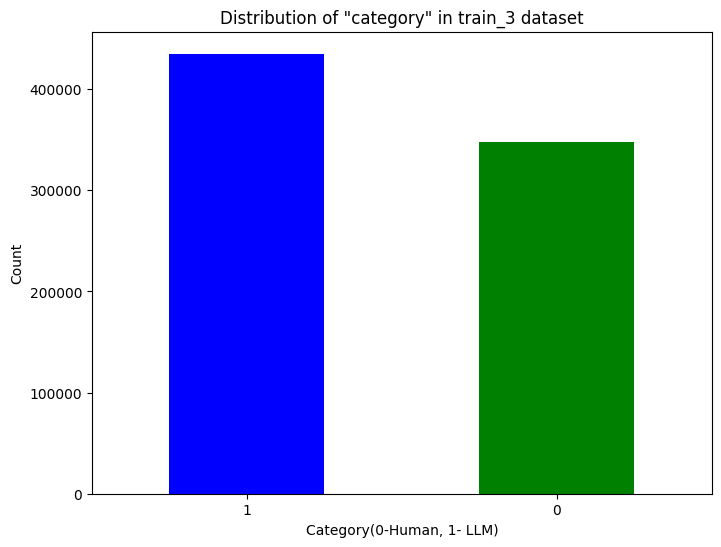

In [31]:
plt.figure(figsize=(8, 6))
train_3['Category'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.title('Distribution of "category" in train_3 dataset')
plt.xlabel('Category(0-Human, 1- LLM)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show() 

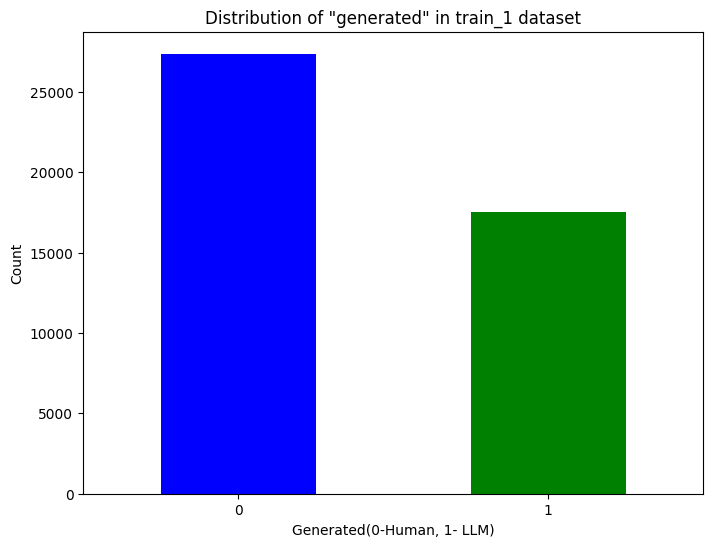

In [32]:
plt.figure(figsize=(8, 6))
train_1['label'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.title('Distribution of "generated" in train_1 dataset')
plt.xlabel('Generated(0-Human, 1- LLM)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

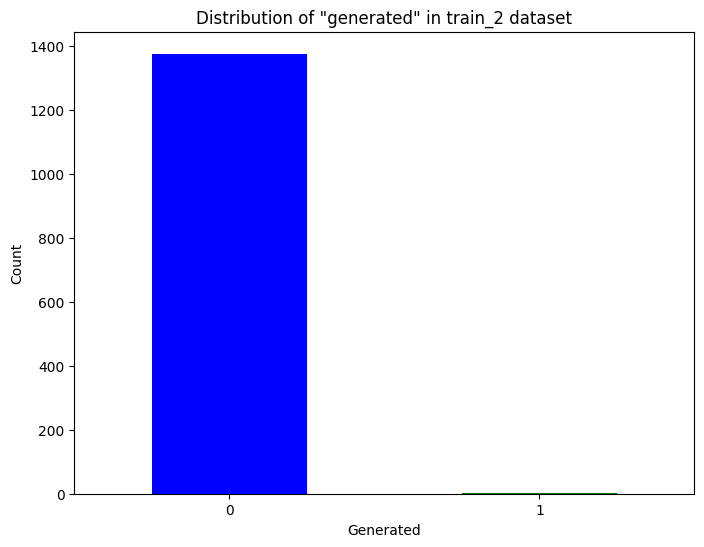

In [7]:
plt.figure(figsize=(8, 6))
train_2['generated'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.title('Distribution of "generated" in train_2 dataset')
plt.xlabel('Generated (0-Human)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [36]:
train_3_selected

,text,label
0,"Federal law supersedes state law, and cannabis...",1
1,Miles feels restless after working all day. He...,1
2,So first of I am danish. That means that I fol...,1
3,In this paper we present a novel rule-based ap...,1
4,"Most social progressives, love democracy, and ...",1
...,...,...
788917,"\nIn the vast expanse of time, where the echoe...",1
788918,"\nThe phenomenon of brain drain, particularly ...",1
788919,\nThe Influence of Climate Change on Marine Ec...,1
788920,\nTitle: The Case for Limiting Car Usage: Navi...,1


In [37]:
import pandas as pd

train_1_selected = train_1[['text', 'label']].copy()

train_2_selected = train_2[['text', 'generated']].rename(columns={'generated': 'label'}).copy()

train_3_selected=train_3[['text','Category']].rename(columns={'Category': 'label'}).copy()

combined_data = pd.concat([train_1_selected, train_2_selected,train_3_selected], ignore_index=True)

print(combined_data)

                                                     text  label
0       Phones\n\nModern humans today are always on th...      0
1       This essay will explain if drivers should or s...      0
2       Driving while the use of cellular devices\n\nT...      0
3       Phones & Driving\n\nDrivers should not be able...      0
4       Cell Phone Operation While Driving\n\nThe abil...      0
...                                                   ...    ...
829070  \nIn the vast expanse of time, where the echoe...      1
829071  \nThe phenomenon of brain drain, particularly ...      1
829072  \nThe Influence of Climate Change on Marine Ec...      1
829073  \nTitle: The Case for Limiting Car Usage: Navi...      1
829074  \nIn the vast expanse of a globalized society,...      1

[829075 rows x 2 columns]


In [38]:
combined_data.head()

,text,label
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


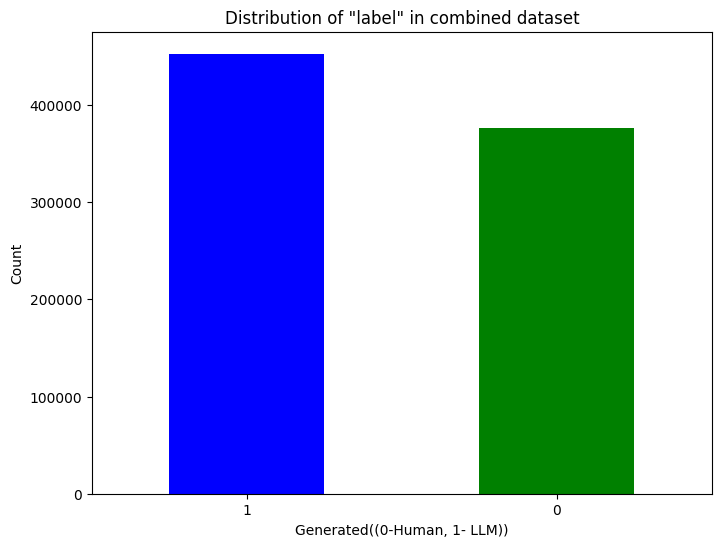

In [40]:
plt.figure(figsize=(8, 6))
combined_data['label'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.title('Distribution of "label" in combined dataset')
plt.xlabel('Generated((0-Human, 1- LLM))')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [41]:
combined_data['label'].value_counts()

label
1    452637
0    376438
Name: count, dtype: int64

In [42]:
student_data = pd.read_csv("train.csv")

In [44]:
student_data.drop("essay_id",axis = 1,inplace = True)

In [45]:
student_data.head()

,full_text,score
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\n\nThis is a letter to arg...",3


In [53]:
temporary_student_data = student_data.query("score>=0").reset_index(drop = True)

In [54]:
temporary_student_data.shape

(17307, 2)

In [55]:
student_data.shape

(17307, 2)

In [56]:
temporary_student_data["label"] = 0

In [57]:
temporary_student_data = temporary_student_data.rename(columns = {"full_text":"text"}).drop("score",axis = 1)

In [59]:
temporary_student_data

,text,label
0,Many people have car where they live. The thin...,0
1,I am a scientist at NASA that is discussing th...,0
2,People always wish they had the same technolog...,0
3,"We all heard about Venus, the planet without a...",0
4,"Dear, State Senator\n\nThis is a letter to arg...",0
...,...,...
17302,"the story "" The Challenge of Exploing Venus "" ...",0
17303,Technology has changed a lot of ways that we l...,0
17304,If you don't like sitting around all day than ...,0
17305,"In ""The Challenge of Exporing Venus,"" the auth...",0


In [60]:
combined_data_2=pd.concat([combined_data,temporary_student_data],ignore_index=True)

In [61]:
combined_data_2

,text,label
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0
...,...,...
846377,"the story "" The Challenge of Exploing Venus "" ...",0
846378,Technology has changed a lot of ways that we l...,0
846379,If you don't like sitting around all day than ...,0
846380,"In ""The Challenge of Exporing Venus,"" the auth...",0


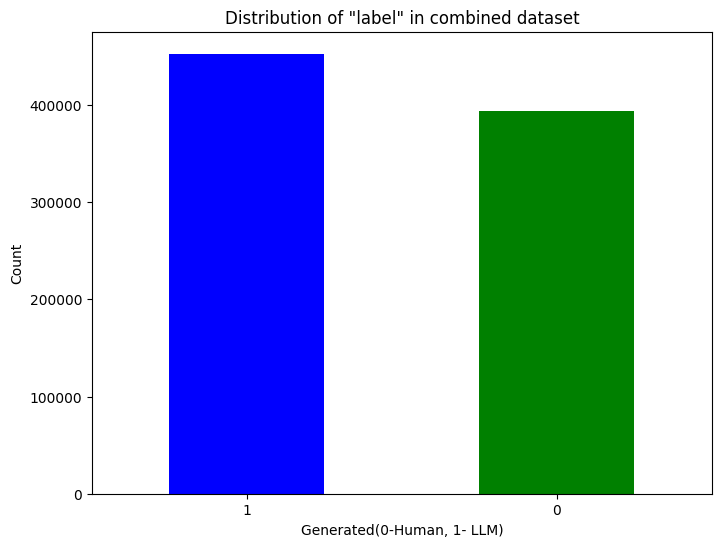

In [65]:
plt.figure(figsize=(8, 6))
combined_data_2['label'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.title('Distribution of "label" in combined dataset')
plt.xlabel('Generated(0-Human, 1- LLM)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [66]:
combined_data_2['label'].value_counts()

label
1    452637
0    393745
Name: count, dtype: int64

In [74]:
dataset=combined_data_2.groupby('label').apply(lambda x: x.sample(n=50000, random_state=42)).reset_index(drop=True)

C:\Users\Jaganath\AppData\Local\Temp\ipykernel_2792\793107566.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset=combined_data_2.groupby('label').apply(lambda x: x.sample(n=50000, random_state=42)).reset_index(drop=True)


In [77]:
dataset['label'].value_counts()

label
0    50000
1    50000
Name: count, dtype: int64

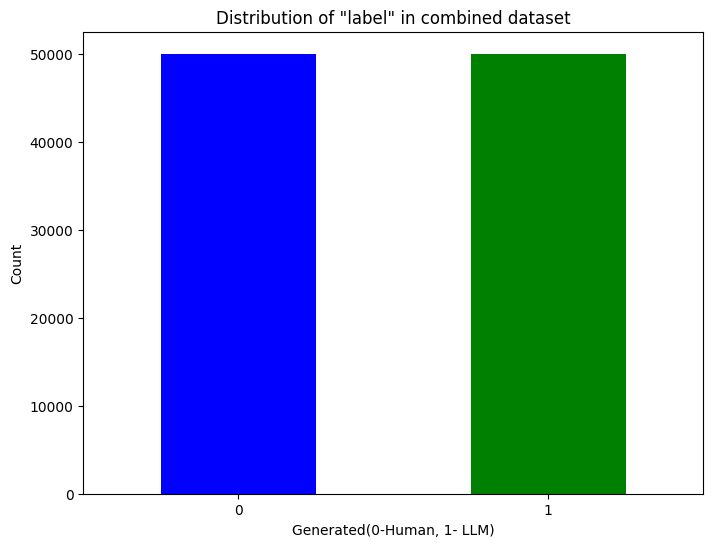

In [78]:
plt.figure(figsize=(8, 6))
dataset['label'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.title('Distribution of "label" in combined dataset')
plt.xlabel('Generated(0-Human, 1- LLM)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [79]:
import spacy

In [80]:
nlp = spacy.load("en_core_web_sm")

In [81]:
print(dataset["text"][10])

The United Nations Environmental Program and Sustainable Development Goals Essay

The United Nations Environmental Programme is an international organization that plays a significant role in the protection of the environment. Over the decades, the intensification of human activities led to the overexploitation of natural resources. As an organ of the United Nations, UNEP concentrates on the implementation of guidelines cultivating the restoration of the deprived habitat. One of the major environmental policies geared by the organization is the Sustainable Development Goals (Mavroeidis et al., 2017). It is essential to determine the interdependence and impact of poor disposal of effluents from different industries and the emerging trend in the increase in human population and technological advancements. An excellent example of interdependence includes the incorporation of strategies to reduce waste disposal to the environment to attain universality despite the dynamic increase in the hu

In [82]:
print(dataset["text"][10000])

Workplace Violence in the Emergency Department Term Paper

Introduction

Within the clinical practice, there is an issue of nurses neglecting to report violent incidents, especially when it comes to the environment of emergency departments. It is important to educate nurses about the need not to overlook this issue and eliminate the negative emotions that persist in emergency care settings. Despite the fact that in emergency rooms, nurses are put under pressure to ensure a high quality of care, it is imperative to preserve their personal well-being to be effective in the workplace. Thus, the purpose of the current paper is to present a PICOT question on the issue of reporting violent accidents as present evidence to supplement the research on the topic.

Background

There is a steady increase in the rate of violence at emergency departments as well as other medical settings. The escalation of patients’ pain and negative emotions accompanied by the presence of “disruptive individuals tu

In [83]:
def countCapitalWords(sentence:str):
    return sum(1 for word in sentence.split(" ") if word and (64< ord(word[0]) < 91))

def countCapitalLetters(sentence:str):
    return sum(1 for word in sentence.split(" ") for ch in word if 'A' <= ch <= 'Z')

def countPunctuations(sentence:str):
    punctuation = set(string.punctuation)
    return sum(1 for word in sentence.split(" ") for ch in word if ch in punctuation)

def countWords(sentence:str):
    return len(sentence.split(" "))

In [84]:
def extract_pos(combined_df):
    pos_tags = {
        "ADJ": [],
        "ADP": [],
        "ADV": [],
        "AUX": [],
        "CCONJ": [],
        "DET": [],
        "INTJ": [],
        "NOUN": [],
        "NUM": [],
        "PART": [],
        "PRON": [],
        "PROPN": [],
        "PUNCT": [],
        "SCONJ": [],
        "SYM": [],
        "VERB": [],
    }

    def posExtractor(sentence):
        hashmap = Counter([word.pos_ for word in nlp(sentence)])
        for k in pos_tags.keys():
            if k in hashmap:
                pos_tags[k].append(hashmap[k])
            else:
                pos_tags[k].append(0)

    for sentence in tqdm(combined_df["text"]):
        posExtractor(sentence)
    return pos_tags

In [86]:
for k,v in extract_pos(dataset).items():
    dataset[k] = v

100%|██████████| 100000/100000 [1:32:13<00:00, 18.07it/s] 


In [88]:
%%time
dataset["word_counts"] = dataset["text"].apply(countWords)
dataset["capital_words"] = dataset["text"].apply(countCapitalWords)
dataset["capital_letters"] = dataset["text"].apply(countCapitalLetters)
dataset["punctuations"] = dataset["text"].apply(countPunctuations)

CPU times: total: 36.3 s
Wall time: 48.3 s


In [89]:
dataset.head()

,text,label,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,...,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,word_counts,capital_words,capital_letters,punctuations
0,Robert Frost “The Road Not Taken” Literature A...,0,90,129,51,76,38,164,1,251,...,89,108,199,36,7,137,1217,153,219,177
1,Worst management I have ever encountered. Zipp...,0,12,17,9,11,10,17,1,34,...,32,7,23,3,0,31,196,23,24,27
2,I believe that the writer has meant this essay...,0,13,24,8,12,3,28,0,48,...,18,2,20,4,0,17,189,12,14,21
3,[substeps] Avoid paper bags with a clay or wax...,0,1,3,1,2,1,5,0,12,...,2,0,4,0,0,5,32,2,2,6
4,Does Political Participation Challenge Democra...,0,144,160,43,91,53,108,0,317,...,59,88,165,18,1,142,1267,130,171,158


In [90]:
dataset.to_csv("combined_data.csv", sep=',', index=False, encoding='utf-8')

In [91]:
temp = dataset[dataset.columns[1:]]

In [92]:
temp.columns

Index(['label', 'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN',
       'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB',
       'word_counts', 'capital_words', 'capital_letters', 'punctuations'],
      dtype='object')

In [93]:
temp.corr()[:1]

,label,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,...,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,word_counts,capital_words,capital_letters,punctuations
label,1.0,-0.186345,-0.216221,-0.212896,-0.257396,-0.17921,-0.233841,-0.056235,-0.207088,-0.197995,...,-0.224803,-0.228488,-0.22649,-0.25367,-0.154141,-0.221723,-0.177021,-0.245387,-0.243943,-0.218731


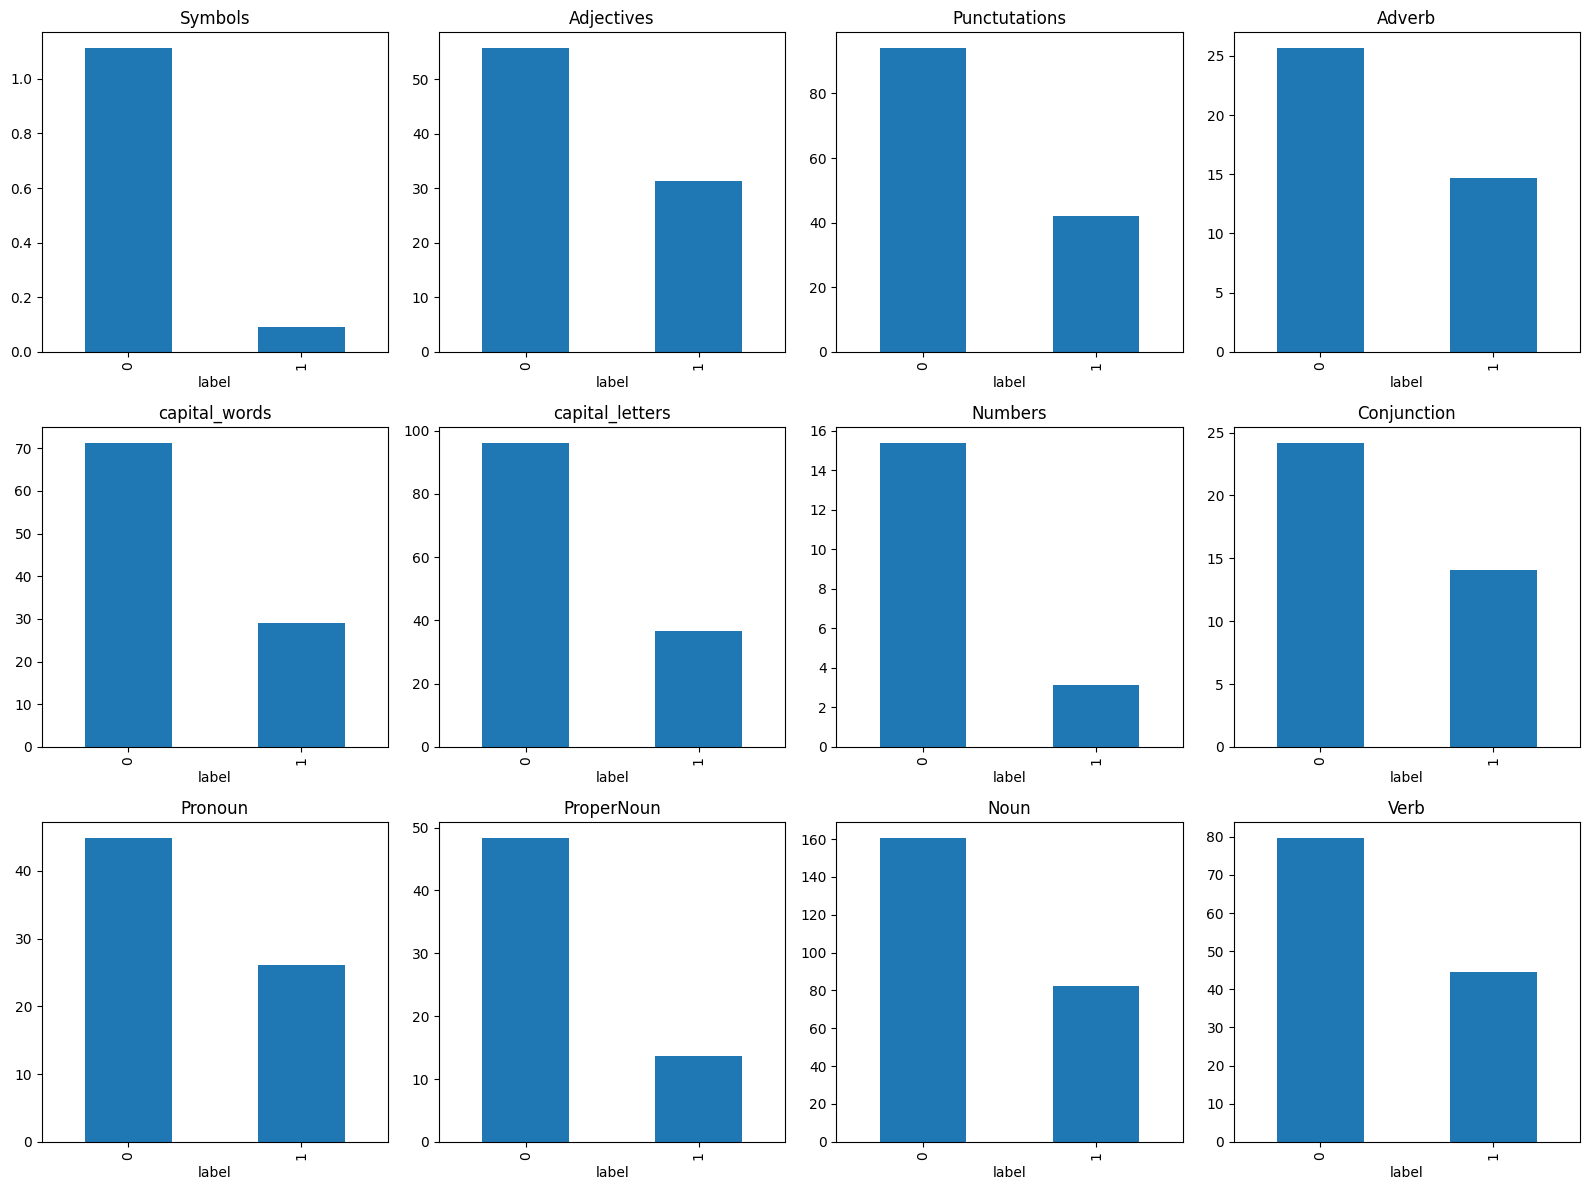

In [94]:
fig,ax = plt.subplots(3,4,figsize=(16,12))
temp.groupby("label")["SYM"].mean().plot(kind = "bar",title = "Symbols",ax = ax[0,0])
temp.groupby("label")["ADJ"].mean().plot(kind = "bar",title = "Adjectives", ax= ax[0,1])
temp.groupby("label")["PUNCT"].mean().plot(kind = "bar",title = "Punctutations",ax = ax[0,2])
temp.groupby("label")["ADV"].mean().plot(kind = "bar",title = "Adverb",ax = ax[0,3])
temp.groupby("label")["capital_words"].mean().plot(kind = "bar",title = "capital_words",ax = ax[1,0])
temp.groupby("label")["capital_letters"].mean().plot(kind = "bar",title = "capital_letters",ax = ax[1,1])
temp.groupby("label")["NUM"].mean().plot(kind = "bar",title = "Numbers",ax = ax[1,2])
temp.groupby("label")["CCONJ"].mean().plot(kind = "bar",title = "Conjunction",ax = ax[1,3])
temp.groupby("label")["PRON"].mean().plot(kind = "bar",title = "Pronoun",ax = ax[2,0])
temp.groupby("label")["PROPN"].mean().plot(kind = "bar",title = "ProperNoun",ax = ax[2,1])
temp.groupby("label")["NOUN"].mean().plot(kind = "bar",title = "Noun",ax = ax[2,2])
temp.groupby("label")["VERB"].mean().plot(kind = "bar",title = "Verb",ax = ax[2,3])

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Avg. Word Count'}, xlabel='label'>

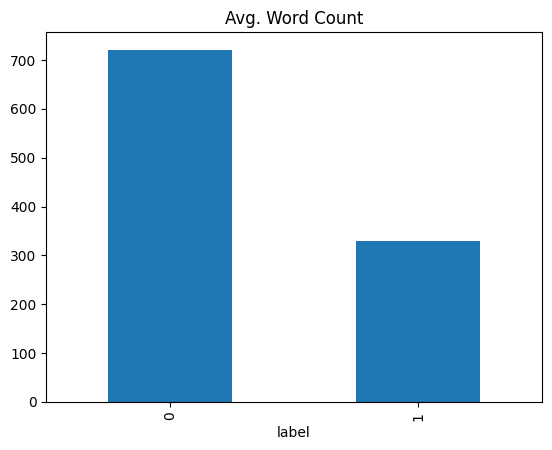

In [95]:
temp.groupby("label")["word_counts"].mean().plot(kind = "bar",title = "Avg. Word Count")

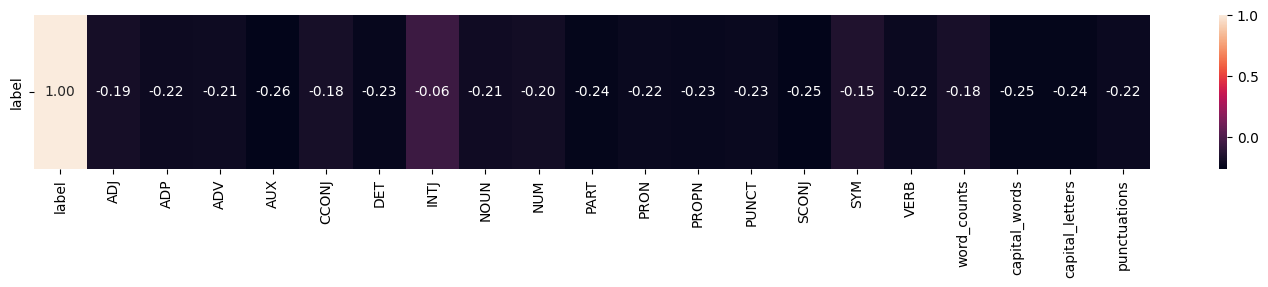

In [96]:
plt.figure(figsize = (18,2))
sns.heatmap(temp.corr()[:1],fmt=".2f",annot = True)
plt.show()

In [4]:
combined_df=pd.read_csv("combined_data.csv")

In [5]:
combined_df.shape

(100000, 22)

In [6]:
combined_df.head()

,text,label,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,...,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,word_counts,capital_words,capital_letters,punctuations
0,Robert Frost “The Road Not Taken” Literature A...,0,90,129,51,76,38,164,1,251,...,89,108,199,36,7,137,1217,153,219,177
1,Worst management I have ever encountered. Zipp...,0,12,17,9,11,10,17,1,34,...,32,7,23,3,0,31,196,23,24,27
2,I believe that the writer has meant this essay...,0,13,24,8,12,3,28,0,48,...,18,2,20,4,0,17,189,12,14,21
3,[substeps] Avoid paper bags with a clay or wax...,0,1,3,1,2,1,5,0,12,...,2,0,4,0,0,5,32,2,2,6
4,Does Political Participation Challenge Democra...,0,144,160,43,91,53,108,0,317,...,59,88,165,18,1,142,1267,130,171,158


In [7]:
temp = combined_df[combined_df.columns[1:]]

In [8]:
temp.columns

Index(['label', 'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN',
       'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB',
       'word_counts', 'capital_words', 'capital_letters', 'punctuations'],
      dtype='object')

In [9]:
temp.corr()[:1]

,label,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,...,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,word_counts,capital_words,capital_letters,punctuations
label,1.0,-0.186345,-0.216221,-0.212896,-0.257396,-0.17921,-0.233841,-0.056235,-0.207088,-0.197995,...,-0.224803,-0.228488,-0.22649,-0.25367,-0.154141,-0.221723,-0.177021,-0.245387,-0.243943,-0.218731


In [23]:
X_train,X_test,y_train,y_test = train_test_split(temp[temp.columns[1:]],temp["label"],shuffle=True,random_state=42)

In [11]:
model = XGBClassifier(
    n_estimators = 350,
    eval_metric = "error",
    n_jobs = 4,
)

In [12]:
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=4,
              num_parallel_tree=None, random_state=None, ...)

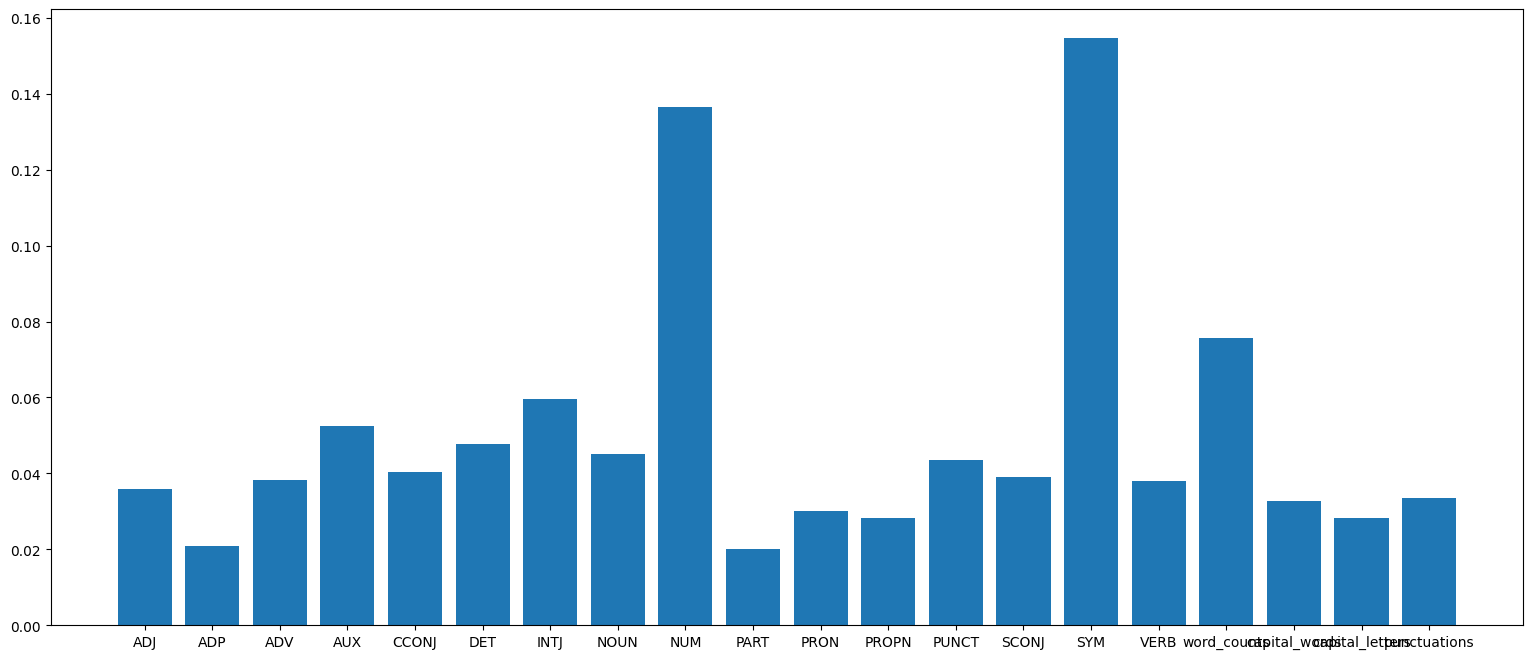

In [13]:
plt.figure(figsize = (19,8))
plt.bar(temp.columns[1:],model.feature_importances_)
plt.show()

In [14]:
y_pred = model.predict(X_test)

In [15]:
cm = confusion_matrix(y_test,y_pred)

In [16]:
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)

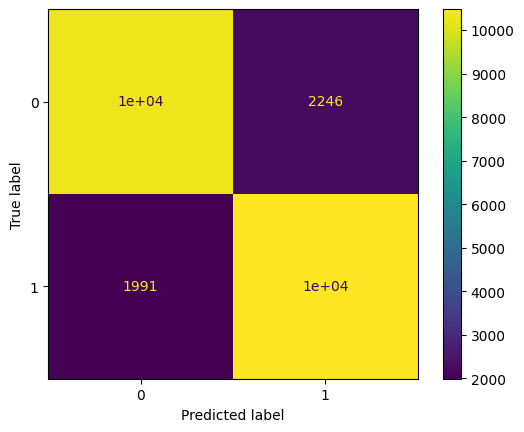

In [17]:
disp.plot()

In [18]:
report = classification_report(y_test,y_pred,output_dict=False)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83     12528
           1       0.82      0.84      0.83     12472

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [19]:
accuracy_score(y_test,y_pred)

0.83052

## Hyper-Parameter Tuning

In [20]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [21]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 350,
        'seed': 0
    }

In [22]:
import xgboost as xgb

In [24]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),eval_metric="error",n_jobs=4)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [25]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

SCORE:                                                 
0.72808                                                
SCORE:                                                                 
0.73548                                                                
SCORE:                                                                 
0.73624                                                                
SCORE:                                                                 
0.72776                                                                
SCORE:                                                                 
0.72792                                                                
SCORE:                                                                 
0.722                                                                  
SCORE:                                                                 
0.73484                                                                
SCORE:                  

In [26]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': np.float64(0.5480306119275065), 'gamma': np.float64(1.0327456396611407), 'max_depth': np.float64(6.0), 'min_child_weight': np.float64(9.0), 'reg_alpha': np.float64(51.0), 'reg_lambda': np.float64(0.628476075276875)}


In [27]:
model = XGBClassifier(
        n_estimators =350, max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
        reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
        colsample_bytree=int(best_hyperparams['colsample_bytree']),eval_metric="error",n_jobs=4
)

In [28]:
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', feature_types=None,
              gamma=np.float64(1.0327456396611407), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=9, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=350,
              n_jobs=4, num_parallel_tree=None, random_state=None, ...)

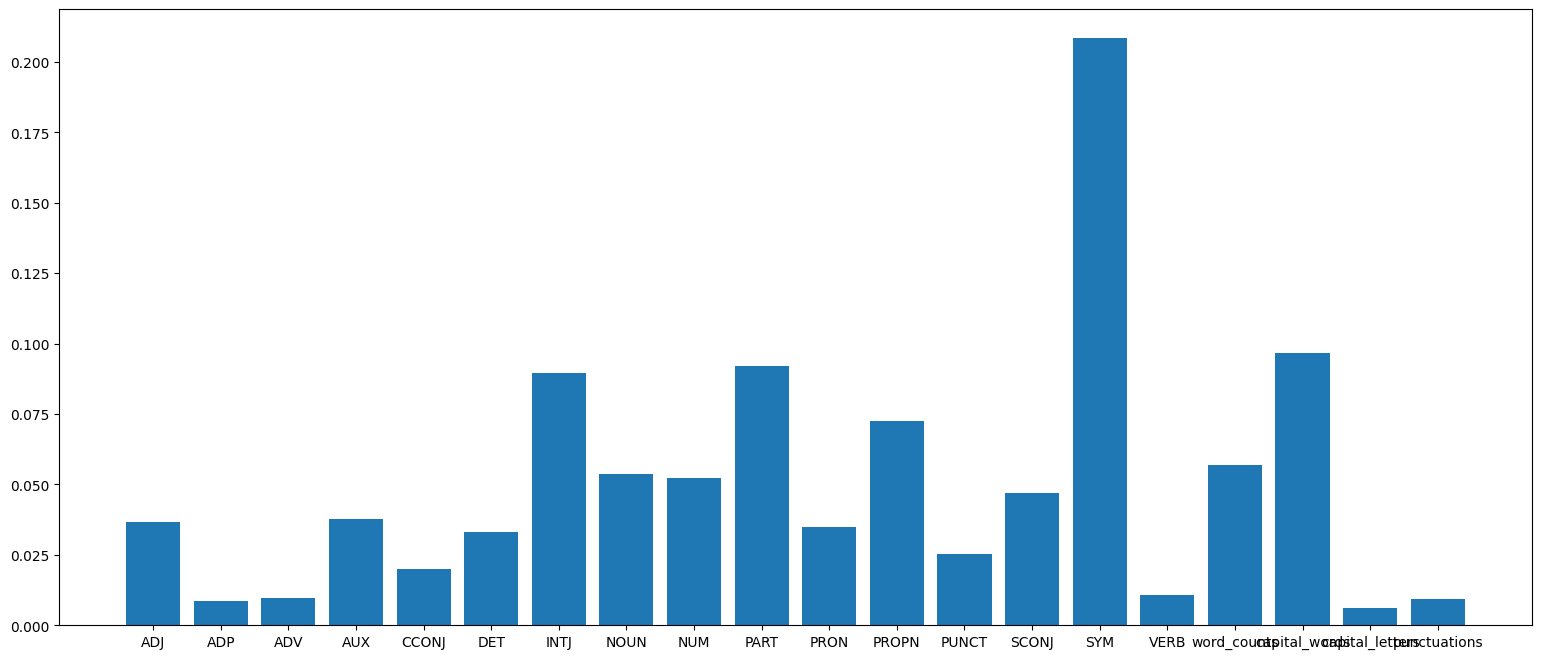

In [29]:
plt.figure(figsize = (19,8))
plt.bar(temp.columns[1:],model.feature_importances_)
plt.show()

In [30]:
y_pred = model.predict(X_test)

In [31]:
cm = confusion_matrix(y_test,y_pred)

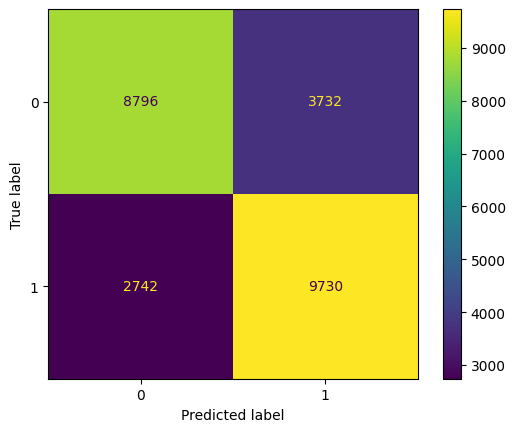

In [32]:
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

In [33]:
report2 = classification_report(y_test,y_pred,output_dict=False)
print(report2)

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     12528
           1       0.72      0.78      0.75     12472

    accuracy                           0.74     25000
   macro avg       0.74      0.74      0.74     25000
weighted avg       0.74      0.74      0.74     25000



In [34]:
accuracy_score(y_test,y_pred)

0.74104

## Using a different model

In [127]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier

In [128]:
sgd_model1 = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber",n_jobs=-1,random_state=42,
                           verbose=10,early_stopping=True,validation_fraction=0.1,class_weight="balanced")
xgb1= XGBClassifier(
        n_estimators =350, max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
        reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
        colsample_bytree=int(best_hyperparams['colsample_bytree']),eval_metric="error",n_jobs=4
)
parames={'n_iter': 300,'verbose': -1,'learning_rate': 0.005689066836106983,
         'colsample_bytree': 0.8915976762048253,
         'colsample_bynode': 0.5942203285139224, 'lambda_l1': 7.6277555139102864,
         'lambda_l2': 6.6591278779517808, 'min_data_in_leaf' : 156, 'max_depth': 11, 'max_bin': 813}
lgb=LGBMClassifier(**parames)

In [129]:
ensemble = VotingClassifier(
    estimators=[
        ('sgd1', sgd_model1),
        ('xgb1',xgb1),
        ('lgb', lgb)
    ],
    weights=[0.10,0.40,0.50],
    voting='soft',
    n_jobs=-1
)


In [130]:
ensemble.fit(X_train,y_train)

VotingClassifier(estimators=[('sgd1',
                              SGDClassifier(class_weight='balanced',
                                            early_stopping=True,
                                            loss='modified_huber',
                                            max_iter=8000, n_jobs=-1,
                                            random_state=42, tol=0.0001,
                                            verbose=10)),
                             ('xgb1',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0, device=None,
                                            early_stopping_rounds=None,...
                                            n_estimators=350, n_jobs=4,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lgb',
                              LGBMClassifier(colsample_bynode=0.5942203285139224,
                                             colsample_bytree=0.8915976762048253,
                                             lambda_l1=7.627755513910286,
                                             lambda_l2=6.65912787795178,
                                             learning_rate=0.005689066836106983,
                                             max_bin=813, max_depth=11,
                                             min_data_in_leaf=156, n_iter=300,
                                             verbose=-1))],
                 n_jobs=-1, voting='soft', weights=[0.1, 0.4, 0.5])

In [131]:
y_pred2 = ensemble.predict(X_test)

In [132]:
cm = confusion_matrix(y_test,y_pred2)

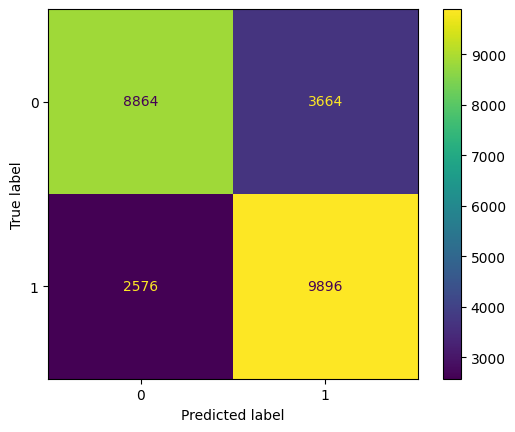

In [133]:
disp = ConfusionMatrixDisplay(cm,display_labels=ensemble.classes_)
disp.plot()

In [134]:
report2 = classification_report(y_test,y_pred2,output_dict=False)
print(report2)

              precision    recall  f1-score   support

           0       0.77      0.71      0.74     12528
           1       0.73      0.79      0.76     12472

    accuracy                           0.75     25000
   macro avg       0.75      0.75      0.75     25000
weighted avg       0.75      0.75      0.75     25000



In [135]:
accuracy_score(y_test,y_pred2)

0.7504

### HyperParameter Tuning

In [136]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier

def objective(trial):
    #SGDClassifier parameters
    sgd_alpha = trial.suggest_float("sgd_alpha", 1e-5, 1e-1, log=True)
    sgd_max_iter = trial.suggest_int("sgd_max_iter", 1000, 10000, step=1000)
    
    # XGBClassifier parameters
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.3, log=True)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 3, 12)
    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 100, 1000, step=50)
    xgb_gamma = trial.suggest_float("xgb_gamma", 0, 5)
    xgb_colsample_bytree = trial.suggest_float("xgb_colsample_bytree", 0.5, 1.0)
    
    # LGBMClassifier parameters
    lgb_learning_rate = trial.suggest_float("lgb_learning_rate", 0.001, 0.1, log=True)
    lgb_max_depth = trial.suggest_int("lgb_max_depth", 3, 12)
    lgb_n_estimators = trial.suggest_int("lgb_n_estimators", 100, 1000, step=50)
    lgb_min_child_samples = trial.suggest_int("lgb_min_child_samples", 10, 200)
    
    # Voting weights for each model
    weight_sgd = trial.suggest_float("weight_sgd", 0.0, 1.0)
    weight_xgb = trial.suggest_float("weight_xgb", 0.0, 1.0)
    weight_lgb = trial.suggest_float("weight_lgb", 0.0, 1.0)

    sgd_model = SGDClassifier(
        alpha=sgd_alpha,
        max_iter=sgd_max_iter,
        tol=1e-4,
        loss="modified_huber",
        n_jobs=-1,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        class_weight="balanced"
    )

    xgb_model = XGBClassifier(
        learning_rate=xgb_learning_rate,
        max_depth=xgb_max_depth,
        n_estimators=xgb_n_estimators,
        gamma=xgb_gamma,
        colsample_bytree=xgb_colsample_bytree,
        eval_metric="error",
        n_jobs=4
    )

    lgb_model = LGBMClassifier(
        learning_rate=lgb_learning_rate,
        max_depth=lgb_max_depth,
        n_estimators=lgb_n_estimators,
        min_child_samples=lgb_min_child_samples
    )


    ensemble = VotingClassifier(
        estimators=[
            ('sgd', sgd_model),
            ('xgb', xgb_model),
            ('lgb', lgb_model)
        ],
        voting='soft',
        weights=[weight_sgd, weight_xgb, weight_lgb],
        n_jobs=-1
    )

  
    total_weight = weight_sgd + weight_xgb + weight_lgb
    if total_weight > 0:
        ensemble.weights = [weight / total_weight for weight in ensemble.weights]

    score = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()

    return score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

c:\Users\Jaganath\anaconda3\envs\pytorch_cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-30 21:44:18,963] A new study created in memory with name: no-name-fd381721-ab2a-4f0d-8ab0-e02ce754ca27
[I 2024-10-30 21:44:33,511] Trial 0 finished with value: 0.6404799999999999 and parameters: {'sgd_alpha': 1.0856844185873596e-05, 'sgd_max_iter': 9000, 'xgb_learning_rate': 0.023298341250498185, 'xgb_max_depth': 9, 'xgb_n_estimators': 500, 'xgb_gamma': 3.3869918986038567, 'xgb_colsample_bytree': 0.6526216211052555, 'lgb_learning_rate': 0.024278461543043466, 'lgb_max_depth': 9, 'lgb_n_estimators': 200, 'lgb_min_child_samples': 189, 'weight_sgd': 0.9459530017013256, 'weight_xgb': 0.07419562333036755, 'weight_lgb': 0.7326597230360424}. Best is trial 0 with value: 0.6404799999999999.
[I 2024-10-30 21:44:40,529] Tr

In [138]:
print("Best parameters found: ", study.best_params)
print("Best cross-validation accuracy: ", study.best_value)

Best parameters found:  {'sgd_alpha': 0.0038680736920269037, 'sgd_max_iter': 7000, 'xgb_learning_rate': 0.07979719480207087, 'xgb_max_depth': 12, 'xgb_n_estimators': 1000, 'xgb_gamma': 0.18178106408962086, 'xgb_colsample_bytree': 0.9795600342861084, 'lgb_learning_rate': 0.06355903422063132, 'lgb_max_depth': 12, 'lgb_n_estimators': 850, 'lgb_min_child_samples': 48, 'weight_sgd': 0.045666669884533245, 'weight_xgb': 0.6242283293393524, 'weight_lgb': 0.9526649401429358}
Best cross-validation accuracy:  0.8312800000000001


In [139]:
best_params=study.best_params
sgd_model = SGDClassifier(
        alpha=best_params['sgd_alpha'],
        max_iter=best_params['sgd_max_iter'],
        tol=1e-4,
        loss="modified_huber",
        n_jobs=-1,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        class_weight="balanced"
    )

xgb_model = XGBClassifier(
        learning_rate=best_params['xgb_learning_rate'],
        max_depth=best_params['xgb_max_depth'],
        n_estimators=best_params['xgb_n_estimators'],
        gamma=best_params['xgb_gamma'],
        colsample_bytree=best_params['xgb_colsample_bytree'],
        eval_metric="error",
        n_jobs=4
    )

lgb_model = LGBMClassifier(
        learning_rate=best_params['lgb_learning_rate'],
        max_depth=best_params['lgb_max_depth'],
        n_estimators=best_params['lgb_n_estimators'],
        min_child_samples=best_params['lgb_min_child_samples']
    )

In [140]:
ensemble = VotingClassifier(
    estimators=[
        ('sgd1', sgd_model),
        ('xgb1',xgb_model),
        ('lgb', lgb_model)
    ],
    weights=[best_params["weight_sgd"],best_params["weight_xgb"],best_params["weight_lgb"]],
    voting='soft',
    n_jobs=-1
)

In [141]:
ensemble.fit(X_train,y_train)

VotingClassifier(estimators=[('sgd1',
                              SGDClassifier(alpha=0.0038680736920269037,
                                            class_weight='balanced',
                                            early_stopping=True,
                                            loss='modified_huber',
                                            max_iter=7000, n_jobs=-1,
                                            random_state=42, tol=0.0001)),
                             ('xgb1',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9795600342861084,
                                            devic...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=4,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lgb',
                              LGBMClassifier(learning_rate=0.06355903422063132,
                                             max_depth=12, min_child_samples=48,
                                             n_estimators=850))],
                 n_jobs=-1, voting='soft',
                 weights=[0.045666669884533245, 0.6242283293393524,
                          0.9526649401429358])

In [142]:
y_pred = ensemble.predict(X_test)

In [143]:
cm = confusion_matrix(y_test,y_pred2)

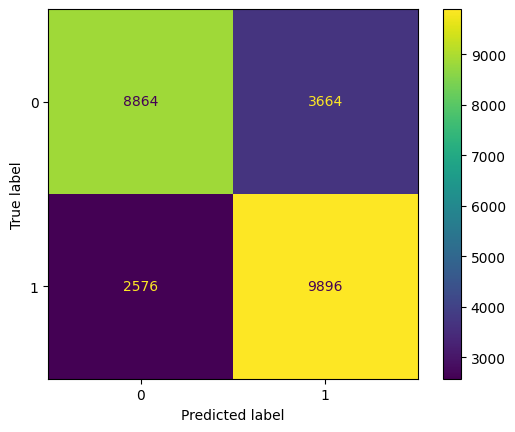

In [144]:
disp = ConfusionMatrixDisplay(cm,display_labels=ensemble.classes_)
disp.plot()

In [145]:
report = classification_report(y_test,y_pred,output_dict=False)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.82      0.83     12528
           1       0.82      0.85      0.84     12472

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



In [146]:
accuracy_score(y_test,y_pred)

0.83524